In [1]:
%load_ext autoreload
%autoreload 2

import os,sys
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.measure import regionprops, label
from skimage.morphology import reconstruction, thin, skeletonize, medial_axis
import collections
from collections import OrderedDict
from PIL import Image, ImageDraw
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import scipy
import skimage.io
import tifffile

from spine import spine, tile, remove_pen_marks, tile_rect, tile_img, tile_rect_img

In [2]:
def plot_im(img):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(img)
    plt.show()

In [3]:
data_dir = "./prostate-cancer-grade-assessment/train_images/" 
mask_dir = "./prostate-cancer-grade-assessment/train_label_masks/" 
csv_file = "./prostate-cancer-grade-assessment/train.csv"
marker_dir = "./prostate-cancer-grade-assessment/marker_images/"
df = pd.read_csv(csv_file)
# img_ids = df['image_id'].tolist()
img_ids = [name[:-10] for name in os.listdir(mask_dir)]
pen_marked_images = [name[:-4] for name in os.listdir(marker_dir)]
kwargs = {'step_size': 5,
           'h_step_size': 0.15,
           'patch_size': 33,
           'slide_thresh': 0.1,
           'overlap_thresh': 0.5,
           'min_size': 1,
            'low_tile_mode': "random",
         'iou_cover_thresh':0.84}
# img_ids = ["b75dff02d2f6c823b0a475ce346be0fb",
#         "01b3d1fe5b0bd538d1e9824fe7d2d24d",
#         "0005f7aaab2800f6170c399693a96917",
#         "000920ad0b612851f8e01bcc880d9b3d",
#         "0018ae58b01bdadc8e347995b69f99aa",
#          "001c62abd11fa4b57bf7a6c603a11bb9",
#          "001d865e65ef5d2579c190a0e0350d8f",
#          "002a4db09dad406c85505a00fb6f6144",
#          "003046e27c8ead3e3db155780dc5498e",
#          "0032bfa835ce0f43a92ae0bbab6871cb",
#          "003a91841da04a5a31f808fb5c21538a",
#           "003d4dd6bd61221ebc0bfb9350db333f",
#           'fd6fe1a3985b17d067f2cb4d5bc1e6e1',
#           'feac91652a1c5accff08217d19116f1c']
# img_ids = ["0b6a90e1c27bf54488c1f7697c6ce599",
#           "255b7b763760bd0cd6774aad75a3e0eb",
#           "037504061b9fba71ef6e24c48c6df44d",
#           "007433133235efc27a39f11df6940829",
#           "0e3b9cd71b3f0049db58e845a781c228",
#           "05a377208625fce1afdc4878e3185ca4"]
img_ids = ['00d8a8c04886379e266406fdeff81c45',
    '01642d24ac5520681d6a20f6c42dc4fe',
    '006f6aa35a78965c92fffd1fbd53a058',
 '00928370e2dfeb8a507667ef1d4efcbb',
 '00d7ec94436e3a1416a3b302914957d3',
 '00e6511435645e50673991768a713c66',
 '01065a75c0dfd95f78893ebbfd3c70b3',
 '01fe87e27518936463e751691db8f730']

In [8]:
ratio = []
tile_number = []
tile_location = {}
N = 36
sz = 256
# number = 97
# in_list = [2,14,23,24,40,56,98,99,21,42,55,80,93,97,76]
# in_list = [80]
# img_ids = [img_ids[i] for i in in_list]
for img_id in tqdm(img_ids[1:2]):
    biopsy = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))
    img0 = cv2.resize(biopsy[-1], (int(biopsy[-1].shape[1]/2), int(biopsy[-1].shape[0]/2)))
    if img_id in pen_marked_images:
        img0, _, _ = remove_pen_marks(img0, scale = 8)    
    result = spine(img0, **kwargs)
    ra = np.sum(np.multiply((result['patch_mask'] > 0).astype('int'), result['mask'])) / np.sum(result['mask'])
    img = biopsy[1]
    mask = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))[1]
    if ra < kwargs['iou_cover_thresh'] or len(result['tile_location']) < N:
        tiles, ra, result['update_patch_mask'] = tile_rect(img, mask, result['mask'], sz=sz,N=N, 
                             overlap_ratio = 0.6, mode = kwargs['low_tile_mode'], **kwargs)
    else:
        tiles = tile(img, mask, result['tile_location'], result['IOU'])
    ratio.append(ra)
    tile_number.append(len(result['tile_location']))
    loc = []
    for i in range(N):
        loc.append(tiles[i]['location'])
    tile_location[img_id] = loc
print(np.mean(ratio), np.mean(tile_number))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



0.8941358822009816 58.0


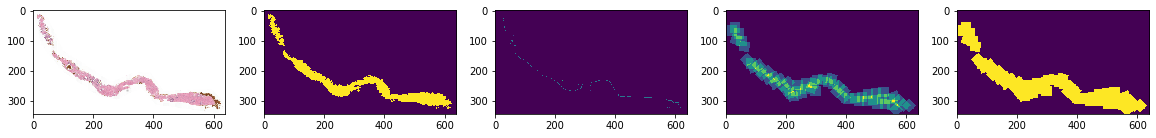

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
ax[0].imshow(img0)
ax[1].imshow(result['mask'])
ax[2].imshow(result['spine'])
ax[3].imshow(result['patch_mask'])
patchMask = (result['patch_mask'] > 0).astype('int')
ax[4].imshow(patchMask)

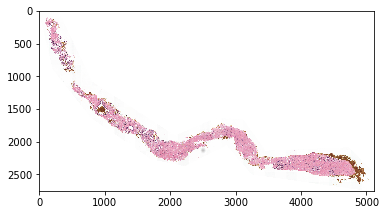

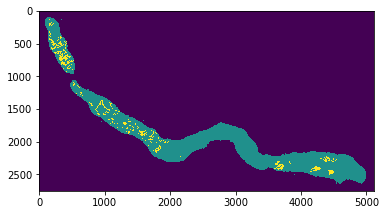

In [10]:
if 'update_patch_mask' in result:
    plot_im(result['update_patch_mask'])
plot_im(img)
plot_im(mask[:,:,0])

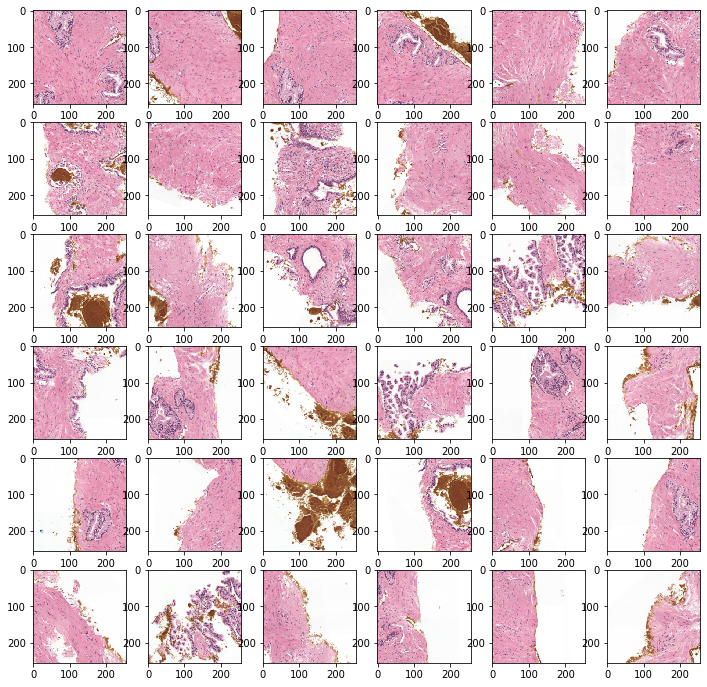

In [11]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
for i in range(36):
    ax[int(i/6),int(i%6)].imshow(tiles[i]['img'])

In [50]:
len(tiles)

36

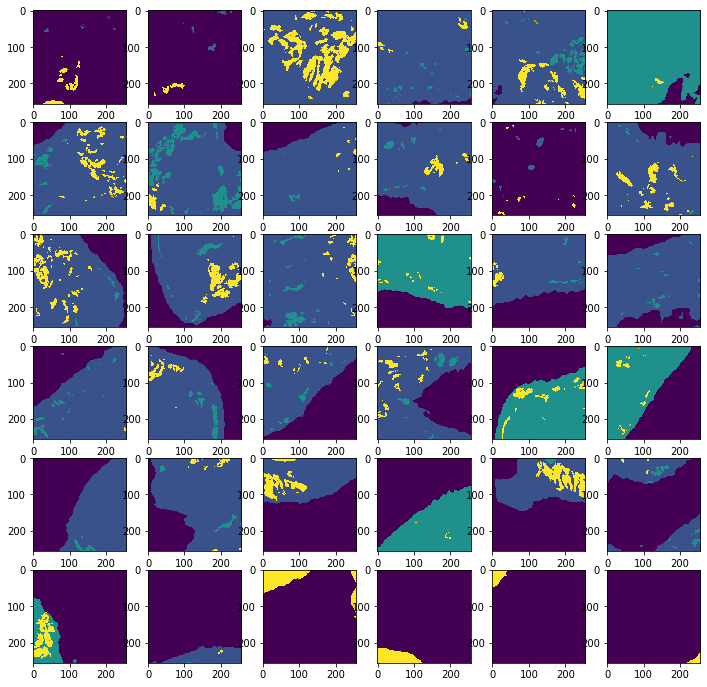

In [64]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
for i in range(36):
    ax[int(i/6),int(i%6)].imshow(tiles[i]['mask'][:,:,0])

In [ ]:
# iou = result['IOU']
# idxsort = np.argsort(iou)[::-1]
# target = idxsort[2]
# location = result['tile_location'][target]

In [ ]:
# cnt = np.expand_dims(location, 1) * 8
# cnt = cnt.astype('int')
# rect = cv2.minAreaRect(cnt)
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# width = int(rect[1][0])
# height = int(rect[1][1])
# src_pts = box.astype("float32")
# dst_pts = np.array([[0, height - 1],
#                     [0, 0],
#                     [width - 1, 0],
#                     [width - 1, height - 1]], dtype="float32")
# M = cv2.getPerspectiveTransform(src_pts, dst_pts)
# warped_img = cv2.warpPerspective(img, M, (width, height), borderValue = (255,255,255))